# Plan C (混合方案 α=74.32%) 灵敏度分析 - 蒙特卡洛模拟

## MCM/ICM 2025 - Question 2: 不确定性量化

**方案说明**: 
- Plan C: 74.32%电梯 + 25.68%火箭的混合运输方案
- α* = 0.7432 (基于综合评分函数优化得出)

**目标**: 
1. 计算时间和成本的概率分布
2. 确定90%和95%置信水平下的分位数值
3. 进行参数灵敏度分析（龙卷风图）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import exp, sqrt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# ==================== 基准参数 (Plan C: 混合方案 α=74.32%) ====================
# 数据来源:
# - Space Elevator: Wikipedia - Space Elevator Economics (Edwards估计)
#   * 边际成本: ~$220/kg ($100/lb) to GEO = $2.2×10^5/ton
#   * 首台建造: ~$40B, 后续 ~$14.3B
#   * 运营成本: $1.56B for first 10 years
# - Rockets: Wikipedia - Falcon Heavy, SpaceX官网
#   * 可回收发射: $97M; 全抛弃: $150M
#   * LEO成本: $2,350/kg; GTO成本: $5,620/kg
#   * 2050技术进步因子: 0.5

BASE_PARAMS = {
    # 总体参数
    'M': 10**8,                 # 总运输量 (吨)
    'alpha': 0.7485,            # 最优混合比例 (74.32%电梯)
    
    # 电梯参数
    'E_E_base': 179000 * 3,     # 电梯基础年运输能力 (吨/年)
    'C_E': 2.2 * 10**5,         # 电梯边际成本 (USD/吨) - Edwards ~$220/kg
    'F_E': 1.2 * 10**8,         # 电梯固定成本 (USD/年)
    'p_E': 0.003,                # 电梯年故障概率
    'sigma_swing': 1.5,         # 缆绳摆动参数 (度)
    'theta_limit': 4.0,         # 摆动角度限制 (度)
    'val_rep_E': 5 * 10**9,     # 电梯维修费用 (USD)
    
    # 火箭参数
    'P_avg': 125,               # 火箭平均载荷 (吨/次)
    'N': 1472,                  # 年发射频率 (次/年)
    'C_R': 3 * 10**5,       # 火箭边际成本 (USD/吨) - $2,350/kg × 0.5
    'F_R': 5 * 10**7,           # 火箭固定成本 (USD/年)
    'q_R': 0.95,                # 火箭发射成功概率
    'val_R': 7.5 * 10**6,       # 单次发射成本 (USD)
}

def calculate_plan_C(params):
    """计算Plan C (混合方案)的时间和成本"""
    M = params['M']
    alpha = params['alpha']
    
    # 电梯参数
    E_E_base = params['E_E_base']
    C_E = params['C_E']
    F_E = params['F_E']
    p_E = params['p_E']
    sigma_swing = params['sigma_swing']
    theta_limit = params['theta_limit']
    val_rep_E = params['val_rep_E']
    
    # 火箭参数
    P_avg = params['P_avg']
    N = params['N']
    C_R = params['C_R']
    q_R = params['q_R']
    val_R = params['val_R']
    
    # 电梯有效运输能力 (考虑摆动)
    ff = 1 - exp(-theta_limit**2 / (2 * sigma_swing**2))
    E_E = E_E_base * ff
    
    # === 电梯部分 (α比例) ===
    M_E = alpha * M  # 电梯承担的运输量
    if alpha > 0:
        E_T_E = M_E / (E_E * (1 - p_E))
        E_C_E = (M_E * C_E + 
                 M_E * F_E / E_E + 
                 M_E * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
    else:
        E_T_E = 0
        E_C_E = 0
    
    # === 火箭部分 (1-α比例) ===
    M_R = (1 - alpha) * M  # 火箭承担的运输量
    if alpha < 1:
        E_T_R = M_R / (P_avg * N * q_R)
        E_C_R = (M_R * C_R / q_R + 
                 val_R * M_R * (1 - q_R) / (P_avg * q_R) +
                 M_R / (N * q_R * P_avg)) / 10**8
    else:
        E_T_R = 0
        E_C_R = 0
    
    # === 混合方案总计 ===
    # 时间: 取最大值(并行运输)
    E_T = max(E_T_E, E_T_R)
    # 成本: 相加
    E_C = E_C_E + E_C_R
    
    return E_T, E_C, E_T_E, E_T_R, E_C_E, E_C_R

# 基准结果
E_T_base, E_C_base, E_T_E, E_T_R, E_C_E, E_C_R = calculate_plan_C(BASE_PARAMS)
print("=" * 70)
print("基准参数下的 Plan C 结果 (α = 74.32%)")
print("=" * 70)
print(f"混合比例 α: {BASE_PARAMS['alpha']*100:.2f}% 电梯 + {(1-BASE_PARAMS['alpha'])*100:.2f}% 火箭")
print(f"电梯边际成本 C_E: ${BASE_PARAMS['C_E']:,.0f}/ton (~$220/kg)")
print(f"火箭边际成本 C_R: ${BASE_PARAMS['C_R']:,.0f}/ton (~$1,175/kg)")
print("-" * 70)
print(f"【电梯部分】时间: {E_T_E:.2f} 年, 成本: {E_C_E:.2f} 亿USD")
print(f"【火箭部分】时间: {E_T_R:.2f} 年, 成本: {E_C_R:.2f} 亿USD")
print("-" * 70)
print(f"【混合方案】时间期望: {E_T_base:.2f} 年")
print(f"【混合方案】成本期望: {E_C_base:.2f} 亿USD")

基准参数下的 Plan C 结果 (α = 74.32%)
混合比例 α: 74.85% 电梯 + 25.15% 火箭
电梯边际成本 C_E: $220,000/ton (~$220/kg)
火箭边际成本 C_R: $300,000/ton (~$1,175/kg)
----------------------------------------------------------------------
【电梯部分】时间: 143.92 年, 成本: 164863.77 亿USD
【火箭部分】时间: 143.88 年, 成本: 80215.26 亿USD
----------------------------------------------------------------------
【混合方案】时间期望: 143.92 年
【混合方案】成本期望: 245079.03 亿USD


In [14]:
# ==================== Monte Carlo Simulation for Plan C ====================
def monte_carlo_simulation_plan_C(n_simulations=1000000, random_seed=42):
    """
    Monte Carlo Simulation for Plan C (α=74.32%)
    
    Uncertain parameters and distributions:
    
    电梯参数:
    1. p_E (failure probability): Beta distribution, mean 0.03
    2. sigma_swing (swing parameter): Normal distribution, mean 1.5, std 0.3
    3. theta_limit (angle limit): Uniform distribution, range [3, 7]
    4. val_rep_E (repair cost): Lognormal distribution, mean 5 billion
    5. C_E (marginal cost): Triangular distribution, [1.5×10^5, 2.2×10^5, 3×10^5]
    
    火箭参数:
    6. q_R (success probability): Beta distribution, mean 0.95
    7. C_R (marginal cost): Triangular distribution, [0.8×10^6, 1.175×10^6, 1.5×10^6]
    8. P_avg (payload): Normal distribution, mean 125, std 10
    
    混合比例:
    9. alpha: Normal distribution, mean 0.7432, std 0.02 (小幅波动)
    """
    np.random.seed(random_seed)
    
    # ========== 电梯参数分布 ==========
    # p_E: Beta distribution (mean ≈ 0.03)
    p_E_samples = np.random.beta(a=3, b=97, size=n_simulations)
    
    # sigma_swing: Truncated normal distribution
    sigma_swing_samples = np.clip(
        np.random.normal(1.5, 0.3, size=n_simulations), 0.8, 2.5
    )
    
    # theta_limit: Uniform distribution [3, 7]
    theta_limit_samples = np.random.uniform(3, 7, size=n_simulations)
    
    # val_rep_E: Lognormal distribution
    val_rep_E_samples = np.random.lognormal(
        mean=np.log(5e9), sigma=0.3, size=n_simulations
    )
    
    # C_E: Triangular distribution
    C_E_samples = np.random.triangular(
        left=1.5e5, mode=2.2e5, right=3e5, size=n_simulations
    )
    
    # ========== 火箭参数分布 ==========
    # q_R: Beta distribution (mean ≈ 0.95)
    q_R_samples = np.random.beta(a=19, b=1, size=n_simulations)  # mean ≈ 0.95
    
    # C_R: Triangular distribution (火箭边际成本)
    C_R_samples = np.random.triangular(
        left=0.8e6, mode=1.175e6, right=1.5e6, size=n_simulations
    )
    
    # P_avg: Normal distribution (火箭载荷)
    P_avg_samples = np.clip(
        np.random.normal(125, 10, size=n_simulations), 100, 150
    )
    
    # ========== 混合比例分布 ==========
    # alpha: Normal distribution with small variance
    alpha_samples = np.clip(
        np.random.normal(0.7432, 0.02, size=n_simulations), 0.65, 0.85
    )
    
    # ========== 固定参数 ==========
    M = BASE_PARAMS['M']
    E_E_base = BASE_PARAMS['E_E_base']
    F_E = BASE_PARAMS['F_E']
    N = BASE_PARAMS['N']
    val_R = BASE_PARAMS['val_R']
    
    # ========== 向量化计算 ==========
    # 电梯有效运输能力
    ff = 1 - np.exp(-theta_limit_samples**2 / (2 * sigma_swing_samples**2))
    E_E = E_E_base * ff
    
    # 电梯部分
    M_E = alpha_samples * M
    T_E = M_E / (E_E * (1 - p_E_samples))
    C_E_total = (M_E * C_E_samples + 
                 M_E * F_E / E_E + 
                 M_E * p_E_samples * val_rep_E_samples / (E_E * (1 - p_E_samples))) / 10**8
    
    # 火箭部分
    M_R = (1 - alpha_samples) * M
    T_R = M_R / (P_avg_samples * N * q_R_samples)
    C_R_total = (M_R * C_R_samples / q_R_samples + 
                 val_R * M_R * (1 - q_R_samples) / (P_avg_samples * q_R_samples) +
                 M_R / (N * q_R_samples * P_avg_samples)) / 10**8
    
    # 混合结果
    T_results = np.maximum(T_E, T_R)  # 并行运输取最大
    C_results = C_E_total + C_R_total  # 成本相加
    
    return {
        'T': T_results,
        'C': C_results,
        'T_E': T_E,
        'T_R': T_R,
        'C_E': C_E_total,
        'C_R': C_R_total,
        # 参数样本
        'alpha': alpha_samples,
        'p_E': p_E_samples,
        'sigma_swing': sigma_swing_samples,
        'theta_limit': theta_limit_samples,
        'val_rep_E': val_rep_E_samples,
        'C_E_unit': C_E_samples,
        'q_R': q_R_samples,
        'C_R_unit': C_R_samples,
        'P_avg': P_avg_samples,
    }

# Run Monte Carlo simulation
N_SIM = 1000000
print(f"Running {N_SIM:,} Monte Carlo simulations for Plan C (α=74.32%)...")
mc_results = monte_carlo_simulation_plan_C(n_simulations=N_SIM)
print("Simulation completed!")
print(f"\nα distribution: [{mc_results['alpha'].min():.4f}, {np.median(mc_results['alpha']):.4f}, {mc_results['alpha'].max():.4f}]")
print(f"C_E distribution: [{mc_results['C_E_unit'].min()/1e5:.1f}, {np.median(mc_results['C_E_unit'])/1e5:.1f}, {mc_results['C_E_unit'].max()/1e5:.1f}] × 10^5 USD/ton")
print(f"C_R distribution: [{mc_results['C_R_unit'].min()/1e6:.2f}, {np.median(mc_results['C_R_unit'])/1e6:.2f}, {mc_results['C_R_unit'].max()/1e6:.2f}] × 10^6 USD/ton")

Running 1,000,000 Monte Carlo simulations for Plan C (α=74.32%)...
Simulation completed!

α distribution: [0.6500, 0.7432, 0.8389]
C_E distribution: [1.5, 2.2, 3.0] × 10^5 USD/ton
C_R distribution: [0.80, 1.16, 1.50] × 10^6 USD/ton


In [15]:
# ==================== 统计分析 ====================
def analyze_distribution(data, name, unit):
    """分析分布统计量"""
    analysis = {
        'mean': np.mean(data),
        'median': np.median(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'p5': np.percentile(data, 5),
        'p10': np.percentile(data, 10),
        'p90': np.percentile(data, 90),
        'p95': np.percentile(data, 95),
        'ci_90': [np.percentile(data, 5), np.percentile(data, 95)],
        'ci_95': [np.percentile(data, 2.5), np.percentile(data, 97.5)],
    }
    
    print(f"\n{'='*60}")
    print(f"{name} 分布分析")
    print(f"{'='*60}")
    print(f"均值: {analysis['mean']:.2f} {unit}")
    print(f"中位数: {analysis['median']:.2f} {unit}")
    print(f"标准差: {analysis['std']:.4f} {unit}")
    print(f"范围: [{analysis['min']:.2f}, {analysis['max']:.2f}] {unit}")
    print(f"-"*60)
    print(f"90% 置信区间: [{analysis['ci_90'][0]:.2f}, {analysis['ci_90'][1]:.2f}] {unit}")
    print(f"95% 置信区间: [{analysis['ci_95'][0]:.2f}, {analysis['ci_95'][1]:.2f}] {unit}")
    
    return analysis

# 分析时间分布
T_analysis = analyze_distribution(mc_results['T'], 'Plan C 运输时间', '年')

# 分析成本分布
C_analysis = analyze_distribution(mc_results['C'], 'Plan C 运输成本', '亿USD')

# 分析电梯和火箭各自的分布
print("\n" + "="*60)
print("子系统分布分析")
print("="*60)
print(f"电梯时间 T_E: 均值={np.mean(mc_results['T_E']):.2f}年, 95%={np.percentile(mc_results['T_E'], 95):.2f}年")
print(f"火箭时间 T_R: 均值={np.mean(mc_results['T_R']):.2f}年, 95%={np.percentile(mc_results['T_R'], 95):.2f}年")
print(f"电梯成本 C_E: 均值={np.mean(mc_results['C_E']):.2f}亿, 95%={np.percentile(mc_results['C_E'], 95):.2f}亿")
print(f"火箭成本 C_R: 均值={np.mean(mc_results['C_R']):.2f}亿, 95%={np.percentile(mc_results['C_R'], 95):.2f}亿")


Plan C 运输时间 分布分析
均值: 157.03 年
中位数: 152.81 年
标准差: 14.2976 年
范围: [133.53, 345.16] 年
------------------------------------------------------------
90% 置信区间: [141.90, 185.35] 年
95% 置信区间: [140.68, 193.87] 年

Plan C 运输成本 分布分析
均值: 481294.04 亿USD
中位数: 479470.16 亿USD
标准差: 52748.2726 亿USD
范围: [290497.03, 933742.59] 亿USD
------------------------------------------------------------
90% 置信区间: [397763.15, 570366.00] 亿USD
95% 置信区间: [384254.27, 589224.44] 亿USD

子系统分布分析
电梯时间 T_E: 均值=147.51年, 95%=168.56年
火箭时间 T_R: 均值=148.27年, 95%=181.03年
电梯成本 C_E: 均值=166417.06亿, 95%=205923.56亿
火箭成本 C_R: 均值=314876.99亿, 95%=399700.07亿


In [16]:
# ==================== Key Results: 90%, 95%, and 99% Percentiles ====================
print("\n" + "="*70)
print("🎯 Plan C (α=74.32%) Key Results: Confidence Percentiles")
print("="*70)

# Time percentiles
T_90 = np.percentile(mc_results['T'], 90)
T_95 = np.percentile(mc_results['T'], 95)
T_99 = np.percentile(mc_results['T'], 99)

# Cost percentiles
C_90 = np.percentile(mc_results['C'], 90)
C_95 = np.percentile(mc_results['C'], 95)
C_99 = np.percentile(mc_results['C'], 99)

print(f"""
【Time Analysis - Plan C】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ Mean: {np.mean(mc_results['T']):.2f} years
  ▸ 90% Confidence: Time ≤ {T_90:.2f} years
  ▸ 95% Confidence: Time ≤ {T_95:.2f} years
  ▸ 99% Confidence: Time ≤ {T_99:.2f} years

【Cost Analysis - Plan C】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ Mean: {np.mean(mc_results['C']):.2f} (100M USD)
  ▸ 90% Confidence: Cost ≤ {C_90:.2f} (100M USD)
  ▸ 95% Confidence: Cost ≤ {C_95:.2f} (100M USD)
  ▸ 99% Confidence: Cost ≤ {C_99:.2f} (100M USD)

【Comparison with Baseline】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Baseline Time (α=74.32%): {E_T_base:.2f} years
  Baseline Cost (α=74.32%): {E_C_base:.2f} (100M USD)
  
  Increase relative to baseline:
    95% Time: +{(T_95/E_T_base - 1)*100:.1f}%
    95% Cost: +{(C_95/E_C_base - 1)*100:.1f}%
    99% Time: +{(T_99/E_T_base - 1)*100:.1f}%
    99% Cost: +{(C_99/E_C_base - 1)*100:.1f}%
""")


🎯 Plan C (α=74.32%) Key Results: Confidence Percentiles

【Time Analysis - Plan C】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ Mean: 157.03 years
  ▸ 90% Confidence: Time ≤ 176.49 years
  ▸ 95% Confidence: Time ≤ 185.35 years
  ▸ 99% Confidence: Time ≤ 204.97 years

【Cost Analysis - Plan C】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▸ Mean: 481294.04 (100M USD)
  ▸ 90% Confidence: Cost ≤ 549673.39 (100M USD)
  ▸ 95% Confidence: Cost ≤ 570366.00 (100M USD)
  ▸ 99% Confidence: Cost ≤ 612440.55 (100M USD)

【Comparison with Baseline】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Baseline Time (α=74.32%): 143.92 years
  Baseline Cost (α=74.32%): 245079.03 (100M USD)
  
  Increase relative to baseline:
    95% Time: +28.8%
    95% Cost: +132.7%
    99% Time: +42.4%
    99% Cost: +149.9%



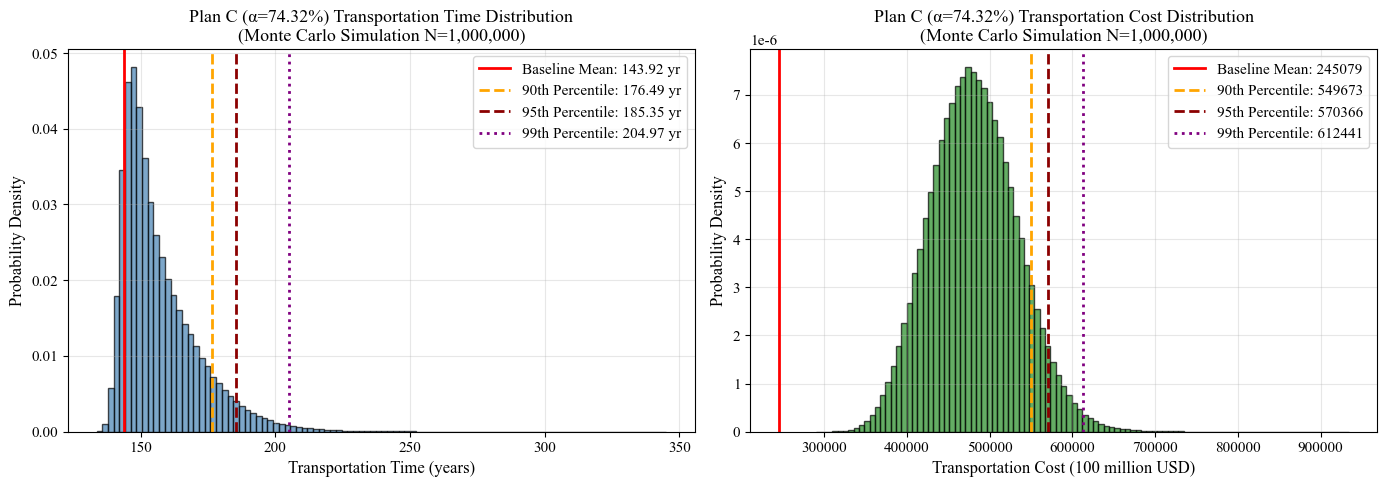

In [17]:
# ==================== Visualization 1: Distribution Histograms ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time distribution
ax1 = axes[0]
ax1.hist(mc_results['T'], bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(E_T_base, color='red', linestyle='-', linewidth=2, label=f'Baseline Mean: {E_T_base:.2f} yr')
ax1.axvline(T_90, color='orange', linestyle='--', linewidth=2, label=f'90th Percentile: {T_90:.2f} yr')
ax1.axvline(T_95, color='darkred', linestyle='--', linewidth=2, label=f'95th Percentile: {T_95:.2f} yr')
ax1.axvline(T_99, color='purple', linestyle=':', linewidth=2, label=f'99th Percentile: {T_99:.2f} yr')
ax1.set_xlabel('Transportation Time (years)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title('Plan C (α=74.32%) Transportation Time Distribution\n(Monte Carlo Simulation N=1,000,000)', fontsize=13)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Cost distribution
ax2 = axes[1]
ax2.hist(mc_results['C'], bins=100, density=True, alpha=0.7, color='forestgreen', edgecolor='black')
ax2.axvline(E_C_base, color='red', linestyle='-', linewidth=2, label=f'Baseline Mean: {E_C_base:.0f}')
ax2.axvline(C_90, color='orange', linestyle='--', linewidth=2, label=f'90th Percentile: {C_90:.0f}')
ax2.axvline(C_95, color='darkred', linestyle='--', linewidth=2, label=f'95th Percentile: {C_95:.0f}')
ax2.axvline(C_99, color='purple', linestyle=':', linewidth=2, label=f'99th Percentile: {C_99:.0f}')
ax2.set_xlabel('Transportation Cost (100 million USD)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.set_title('Plan C (α=74.32%) Transportation Cost Distribution\n(Monte Carlo Simulation N=1,000,000)', fontsize=13)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_C_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

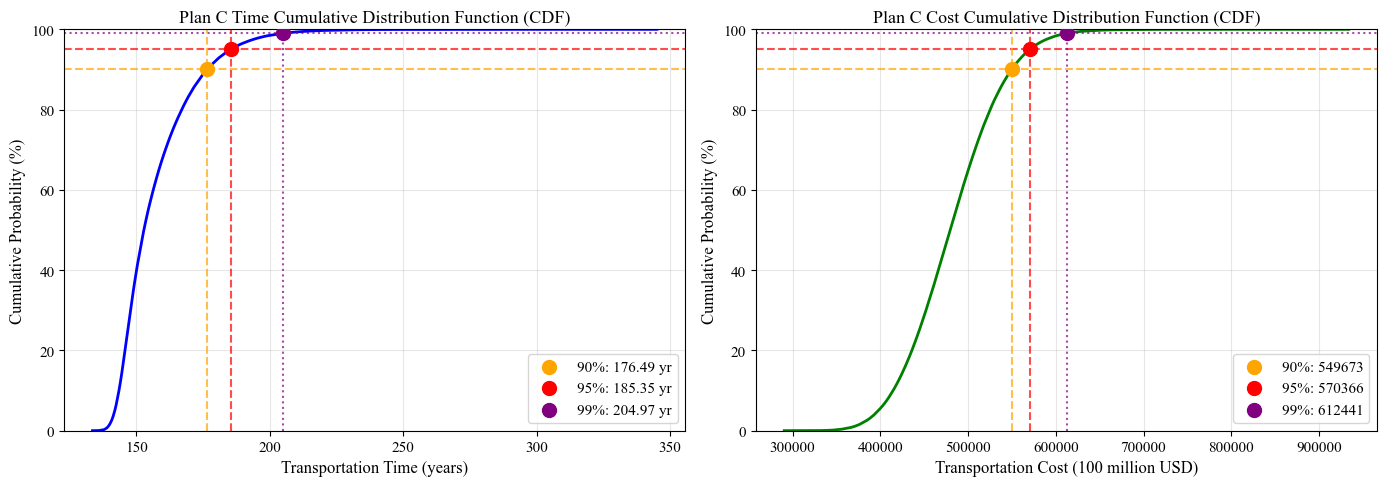

In [18]:
# ==================== Visualization 2: CDF Cumulative Distribution Function ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time CDF
ax1 = axes[0]
T_sorted = np.sort(mc_results['T'])
T_cdf = np.arange(1, len(T_sorted) + 1) / len(T_sorted)
ax1.plot(T_sorted, T_cdf * 100, 'b-', linewidth=2)
ax1.axhline(90, color='orange', linestyle='--', alpha=0.7)
ax1.axhline(95, color='red', linestyle='--', alpha=0.7)
ax1.axhline(99, color='purple', linestyle=':', alpha=0.7)
ax1.axvline(T_90, color='orange', linestyle='--', alpha=0.7)
ax1.axvline(T_95, color='red', linestyle='--', alpha=0.7)
ax1.axvline(T_99, color='purple', linestyle=':', alpha=0.7)
ax1.scatter([T_90], [90], color='orange', s=100, zorder=5, label=f'90%: {T_90:.2f} yr')
ax1.scatter([T_95], [95], color='red', s=100, zorder=5, label=f'95%: {T_95:.2f} yr')
ax1.scatter([T_99], [99], color='purple', s=100, zorder=5, label=f'99%: {T_99:.2f} yr')
ax1.set_xlabel('Transportation Time (years)', fontsize=12)
ax1.set_ylabel('Cumulative Probability (%)', fontsize=12)
ax1.set_title('Plan C Time Cumulative Distribution Function (CDF)', fontsize=13)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Cost CDF
ax2 = axes[1]
C_sorted = np.sort(mc_results['C'])
C_cdf = np.arange(1, len(C_sorted) + 1) / len(C_sorted)
ax2.plot(C_sorted, C_cdf * 100, 'g-', linewidth=2)
ax2.axhline(90, color='orange', linestyle='--', alpha=0.7)
ax2.axhline(95, color='red', linestyle='--', alpha=0.7)
ax2.axhline(99, color='purple', linestyle=':', alpha=0.7)
ax2.axvline(C_90, color='orange', linestyle='--', alpha=0.7)
ax2.axvline(C_95, color='red', linestyle='--', alpha=0.7)
ax2.axvline(C_99, color='purple', linestyle=':', alpha=0.7)
ax2.scatter([C_90], [90], color='orange', s=100, zorder=5, label=f'90%: {C_90:.0f}')
ax2.scatter([C_95], [95], color='red', s=100, zorder=5, label=f'95%: {C_95:.0f}')
ax2.scatter([C_99], [99], color='purple', s=100, zorder=5, label=f'99%: {C_99:.0f}')
ax2.set_xlabel('Transportation Cost (100 million USD)', fontsize=12)
ax2.set_ylabel('Cumulative Probability (%)', fontsize=12)
ax2.set_title('Plan C Cost Cumulative Distribution Function (CDF)', fontsize=13)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../results/sensitivity_C_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# ==================== 龙卷风图: Plan C 参数灵敏度分析 ====================
def tornado_analysis_plan_C(base_params, perturbation=0.2):
    """
    龙卷风图分析 - Plan C 单因素灵敏度
    perturbation: ±20%扰动
    """
    E_T_base, E_C_base, _, _, _, _ = calculate_plan_C(base_params)
    
    # 要分析的参数 (电梯+火箭+混合比例)
    params_to_analyze = [
        'alpha',        # 混合比例
        'p_E',          # 电梯故障概率
        'sigma_swing',  # 电梯摆动参数
        'theta_limit',  # 电梯角度限制
        'val_rep_E',    # 电梯维修费用
        'C_E',          # 电梯边际成本
        'q_R',          # 火箭成功概率
        'C_R',          # 火箭边际成本
        'P_avg',        # 火箭载荷
    ]
    
    sensitivities_T = []
    sensitivities_C = []
    
    for param_name in params_to_analyze:
        # Low value
        params_low = base_params.copy()
        params_low[param_name] = base_params[param_name] * (1 - perturbation)
        T_low, C_low, _, _, _, _ = calculate_plan_C(params_low)
        
        # High value
        params_high = base_params.copy()
        params_high[param_name] = base_params[param_name] * (1 + perturbation)
        T_high, C_high, _, _, _, _ = calculate_plan_C(params_high)
        
        sensitivities_T.append({
            'param': param_name,
            'low': T_low,
            'high': T_high,
            'range': abs(T_high - T_low)
        })
        
        sensitivities_C.append({
            'param': param_name,
            'low': C_low,
            'high': C_high,
            'range': abs(C_high - C_low)
        })
    
    # 按影响大小排序
    sensitivities_T.sort(key=lambda x: x['range'], reverse=True)
    sensitivities_C.sort(key=lambda x: x['range'], reverse=True)
    
    return sensitivities_T, sensitivities_C, E_T_base, E_C_base

sens_T, sens_C, baseline_T, baseline_C = tornado_analysis_plan_C(BASE_PARAMS, perturbation=0.2)

print("\n" + "="*70)
print("Plan C (α=74.32%) 参数灵敏度排序 (±20%扰动)")
print("="*70)
print("\n【时间灵敏度】")
for s in sens_T:
    print(f"  {s['param']:15s}: [{s['low']:.2f}, {s['high']:.2f}] 年, 波动: {s['range']:.4f}年")

print("\n【成本灵敏度】")
for s in sens_C:
    print(f"  {s['param']:15s}: [{s['low']:.0f}, {s['high']:.0f}] 亿USD, 波动: {s['range']:.2f}亿")


Plan C (α=74.32%) 参数灵敏度排序 (±20%扰动)

【时间灵敏度】
  alpha          : [229.52, 172.70] 年, 波动: 56.8203年
  q_R            : [179.85, 143.92] 年, 波动: 35.9325年
  P_avg          : [179.85, 143.92] 年, 波动: 35.9325年
  theta_limit    : [155.81, 143.88] 年, 波动: 11.9344年
  sigma_swing    : [143.88, 152.74] 年, 波动: 8.8564年
  p_E            : [143.88, 144.00] 年, 波动: 0.1239年
  val_rep_E      : [143.92, 143.92] 年, 波动: 0.0000年
  C_E            : [143.92, 143.92] 年, 波动: 0.0000年
  C_R            : [143.92, 143.92] 年, 波动: 0.0000年

【成本灵敏度】
  C_E            : [212145, 278013] 亿USD, 波动: 65868.00亿
  q_R            : [268905, 229195] 亿USD, 波动: 39710.53亿
  C_R            : [229195, 260963] 亿USD, 波动: 31768.42亿
  alpha          : [259853, 230305] 亿USD, 波动: 29547.33亿
  P_avg          : [245278, 244947] 亿USD, 波动: 330.92亿
  theta_limit    : [245095, 245075] 亿USD, 波动: 20.42亿
  sigma_swing    : [245074, 245091] 亿USD, 波动: 16.68亿
  p_E            : [245075, 245083] 亿USD, 波动: 8.66亿
  val_rep_E      : [245075, 245083] 亿USD, 波动: 8

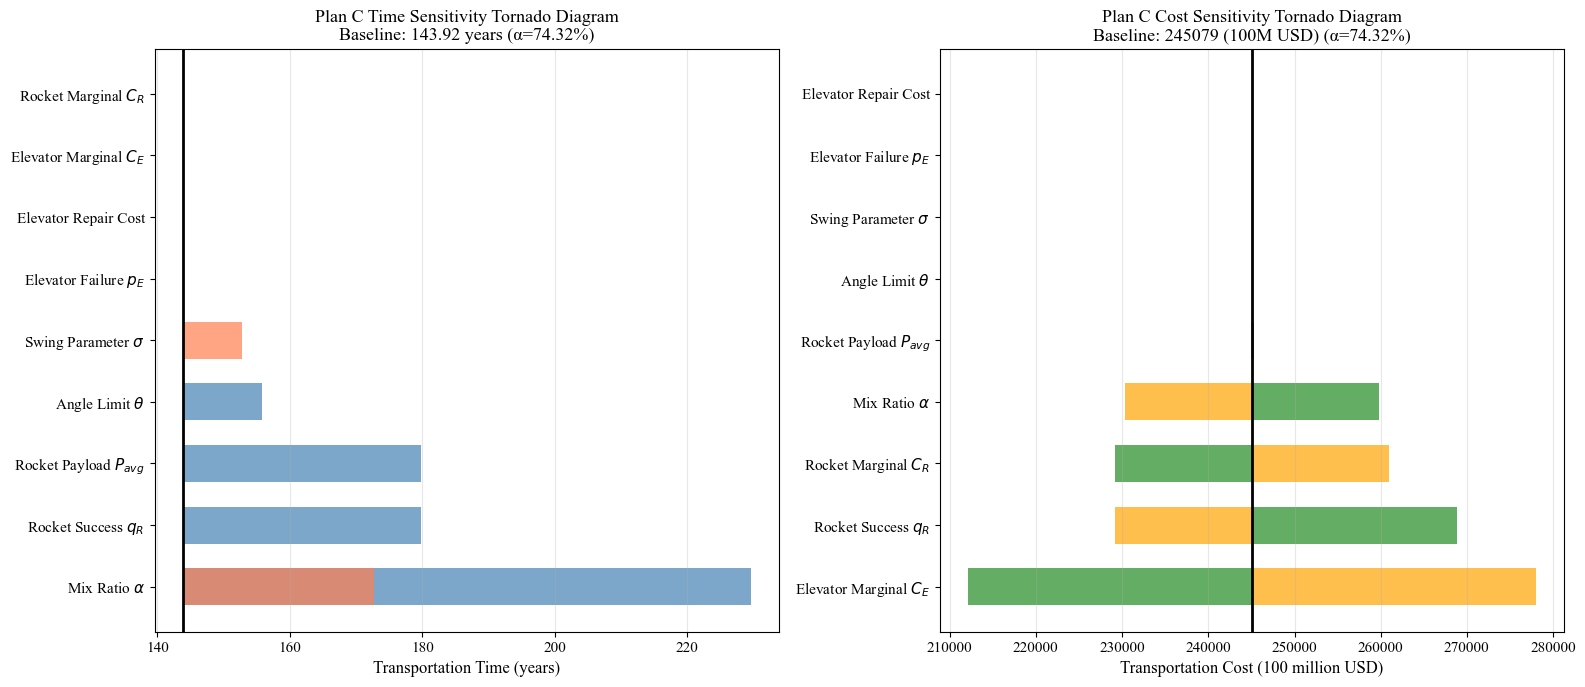

In [20]:
# ==================== Visualization 3: Tornado Diagram for Plan C ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Parameter name mapping (English)
param_labels = {
    'alpha': 'Mix Ratio $\\alpha$',
    'p_E': 'Elevator Failure $p_E$',
    'sigma_swing': 'Swing Parameter $\\sigma$',
    'theta_limit': 'Angle Limit $\\theta$',
    'val_rep_E': 'Elevator Repair Cost',
    'C_E': 'Elevator Marginal $C_E$',
    'F_E': 'Elevator Fixed $F_E$',
    'q_R': 'Rocket Success $q_R$',
    'C_R': 'Rocket Marginal $C_R$',
    'P_avg': 'Rocket Payload $P_{avg}$',
}

# Time Tornado Diagram
ax1 = axes[0]
y_pos = np.arange(len(sens_T))
for i, s in enumerate(sens_T):
    ax1.barh(i, s['low'] - baseline_T, left=baseline_T, height=0.6, 
             color='steelblue', alpha=0.7)
    ax1.barh(i, s['high'] - baseline_T, left=baseline_T, height=0.6, 
             color='coral', alpha=0.7)
ax1.axvline(baseline_T, color='black', linestyle='-', linewidth=2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([param_labels.get(s['param'], s['param']) for s in sens_T])
ax1.set_xlabel('Transportation Time (years)', fontsize=12)
ax1.set_title(f'Plan C Time Sensitivity Tornado Diagram\nBaseline: {baseline_T:.2f} years (α=74.32%)', fontsize=13)
ax1.grid(True, axis='x', alpha=0.3)

# Cost Tornado Diagram
ax2 = axes[1]
for i, s in enumerate(sens_C):
    ax2.barh(i, s['low'] - baseline_C, left=baseline_C, height=0.6, 
             color='forestgreen', alpha=0.7)
    ax2.barh(i, s['high'] - baseline_C, left=baseline_C, height=0.6, 
             color='orange', alpha=0.7)
ax2.axvline(baseline_C, color='black', linestyle='-', linewidth=2)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([param_labels.get(s['param'], s['param']) for s in sens_C])
ax2.set_xlabel('Transportation Cost (100 million USD)', fontsize=12)
ax2.set_title(f'Plan C Cost Sensitivity Tornado Diagram\nBaseline: {baseline_C:.0f} (100M USD) (α=74.32%)', fontsize=13)
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_C_tornado.png', dpi=300, bbox_inches='tight')
plt.show()

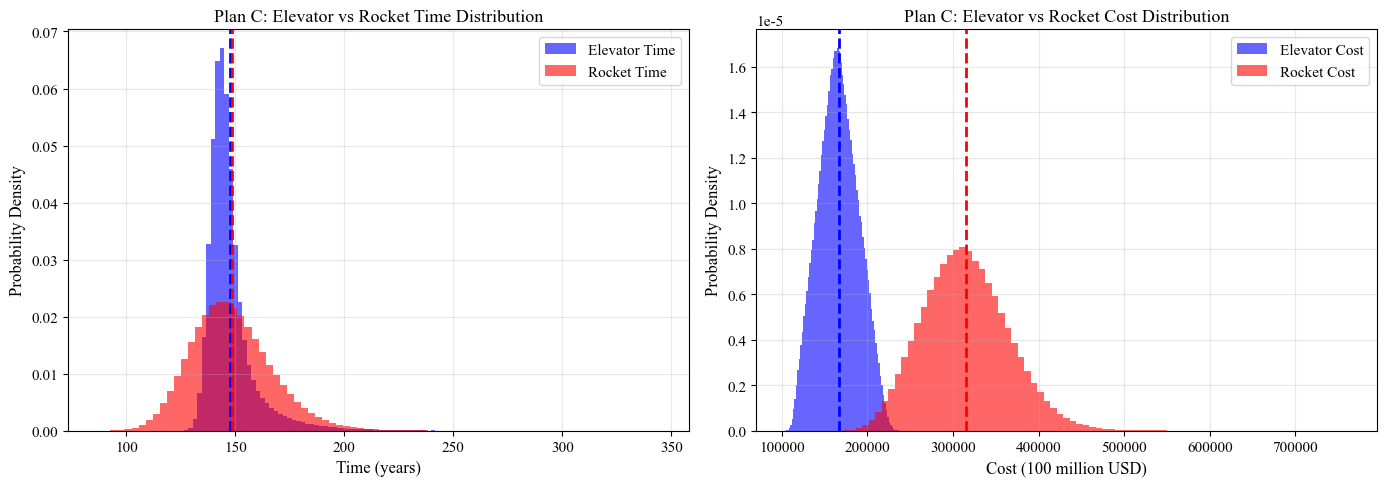


子系统贡献分析
电梯时间占比 (T_E > T_R的概率): 49.4%
电梯成本占比: 34.8%
火箭成本占比: 65.2%


In [21]:
# ==================== Visualization 4: Elevator vs Rocket Contribution ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time comparison
ax1 = axes[0]
ax1.hist(mc_results['T_E'], bins=80, density=True, alpha=0.6, color='blue', label='Elevator Time')
ax1.hist(mc_results['T_R'], bins=80, density=True, alpha=0.6, color='red', label='Rocket Time')
ax1.axvline(np.mean(mc_results['T_E']), color='blue', linestyle='--', linewidth=2)
ax1.axvline(np.mean(mc_results['T_R']), color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title('Plan C: Elevator vs Rocket Time Distribution', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cost comparison
ax2 = axes[1]
ax2.hist(mc_results['C_E'], bins=80, density=True, alpha=0.6, color='blue', label='Elevator Cost')
ax2.hist(mc_results['C_R'], bins=80, density=True, alpha=0.6, color='red', label='Rocket Cost')
ax2.axvline(np.mean(mc_results['C_E']), color='blue', linestyle='--', linewidth=2)
ax2.axvline(np.mean(mc_results['C_R']), color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Cost (100 million USD)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.set_title('Plan C: Elevator vs Rocket Cost Distribution', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_C_subsystems.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\n" + "="*60)
print("子系统贡献分析")
print("="*60)
print(f"电梯时间占比 (T_E > T_R的概率): {np.mean(mc_results['T_E'] > mc_results['T_R'])*100:.1f}%")
print(f"电梯成本占比: {np.mean(mc_results['C_E']/(mc_results['C_E']+mc_results['C_R']))*100:.1f}%")
print(f"火箭成本占比: {np.mean(mc_results['C_R']/(mc_results['C_E']+mc_results['C_R']))*100:.1f}%")

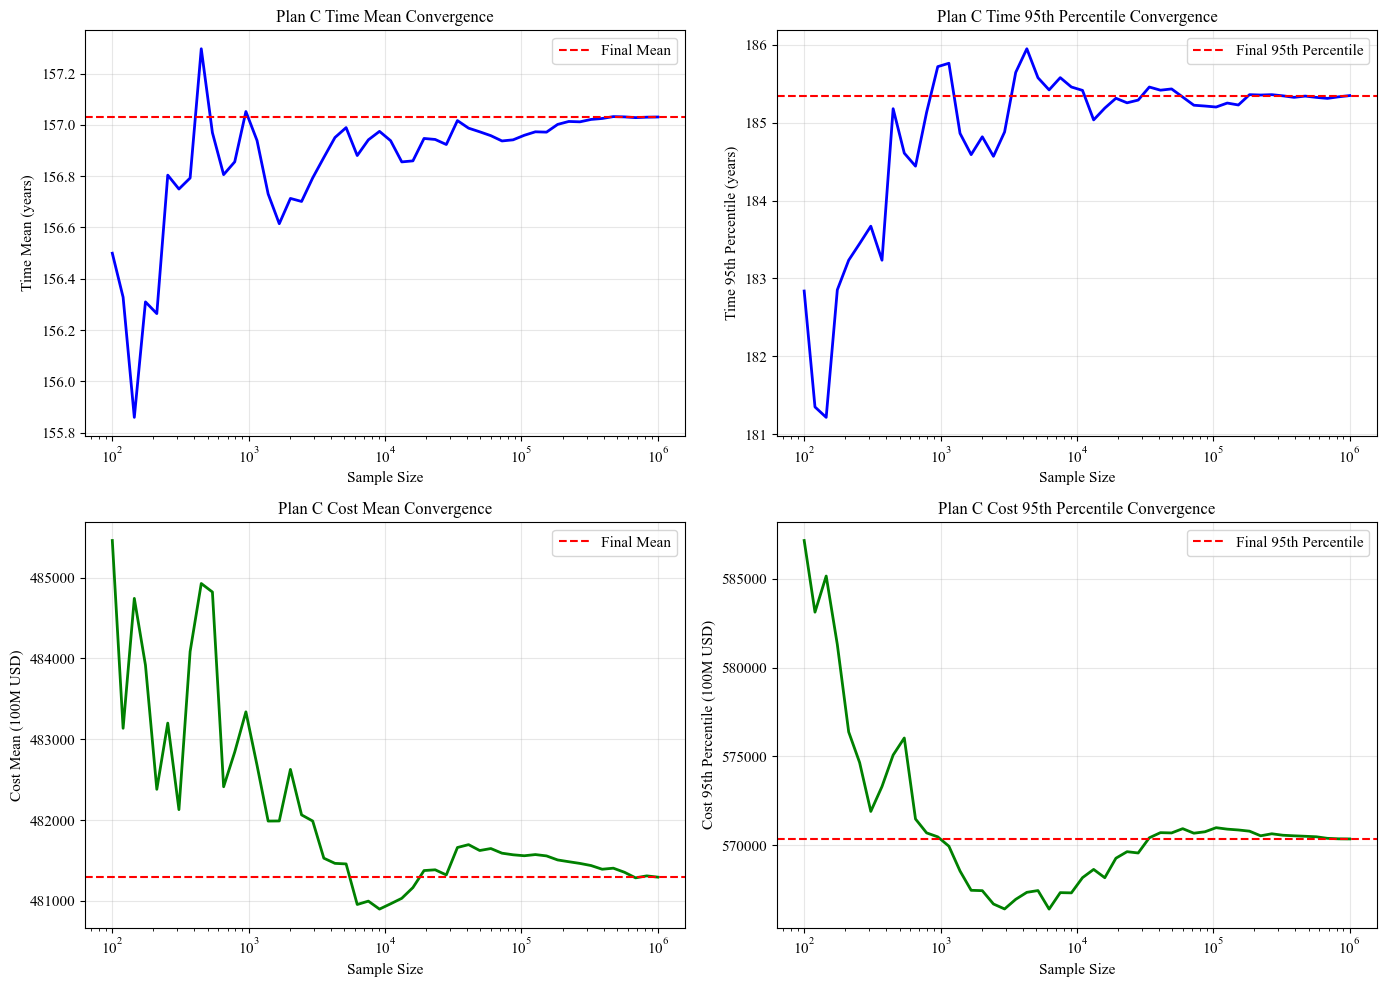


Convergence Test: Curves stabilize as sample size increases, indicating simulation convergence.


In [22]:
# ==================== Convergence Test ====================
def convergence_test(results, metric='T', n_points=50):
    """Test Monte Carlo simulation convergence"""
    data = results[metric]
    n_total = len(data)
    
    sample_sizes = np.logspace(2, np.log10(n_total), n_points).astype(int)
    means = []
    stds = []
    p95s = []
    
    for n in sample_sizes:
        subset = data[:n]
        means.append(np.mean(subset))
        stds.append(np.std(subset))
        p95s.append(np.percentile(subset, 95))
    
    return sample_sizes, means, stds, p95s

# Time convergence
sizes_T, means_T, stds_T, p95s_T = convergence_test(mc_results, 'T')
# Cost convergence
sizes_C, means_C, stds_C, p95s_C = convergence_test(mc_results, 'C')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time Mean Convergence
ax1 = axes[0, 0]
ax1.semilogx(sizes_T, means_T, 'b-', linewidth=2)
ax1.axhline(np.mean(mc_results['T']), color='red', linestyle='--', label='Final Mean')
ax1.set_xlabel('Sample Size', fontsize=11)
ax1.set_ylabel('Time Mean (years)', fontsize=11)
ax1.set_title('Plan C Time Mean Convergence', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time 95th Percentile Convergence
ax2 = axes[0, 1]
ax2.semilogx(sizes_T, p95s_T, 'b-', linewidth=2)
ax2.axhline(T_95, color='red', linestyle='--', label='Final 95th Percentile')
ax2.set_xlabel('Sample Size', fontsize=11)
ax2.set_ylabel('Time 95th Percentile (years)', fontsize=11)
ax2.set_title('Plan C Time 95th Percentile Convergence', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cost Mean Convergence
ax3 = axes[1, 0]
ax3.semilogx(sizes_C, means_C, 'g-', linewidth=2)
ax3.axhline(np.mean(mc_results['C']), color='red', linestyle='--', label='Final Mean')
ax3.set_xlabel('Sample Size', fontsize=11)
ax3.set_ylabel('Cost Mean (100M USD)', fontsize=11)
ax3.set_title('Plan C Cost Mean Convergence', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cost 95th Percentile Convergence
ax4 = axes[1, 1]
ax4.semilogx(sizes_C, p95s_C, 'g-', linewidth=2)
ax4.axhline(C_95, color='red', linestyle='--', label='Final 95th Percentile')
ax4.set_xlabel('Sample Size', fontsize=11)
ax4.set_ylabel('Cost 95th Percentile (100M USD)', fontsize=11)
ax4.set_title('Plan C Cost 95th Percentile Convergence', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sensitivity_C_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConvergence Test: Curves stabilize as sample size increases, indicating simulation convergence.")

In [23]:
# ==================== 最终结论汇总 ====================
print("\n" + "="*70)
print("🎯 Plan C (α=74.32% 混合方案) 灵敏度分析 - 最终结论")
print("="*70)

print(f"""
【方案配置】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  混合比例: α = 74.32% 电梯 + 25.68% 火箭
  总运输量: M = 10^8 吨
  电梯承担: {BASE_PARAMS['alpha']*BASE_PARAMS['M']/10**8:.2f} × 10^8 吨
  火箭承担: {(1-BASE_PARAMS['alpha'])*BASE_PARAMS['M']/10**8:.2f} × 10^8 吨

【蒙特卡洛模拟配置】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  模拟次数: {N_SIM:,}
  随机种子: 42 (可复现)
  
  电梯参数分布:
    • 故障概率 p_E: Beta(3, 97), 均值≈0.03
    • 摆动参数 σ: Normal(1.5, 0.3), 截断[0.8, 2.5]
    • 角度限制 θ: Uniform(3, 7)
    • 维修费用: Lognormal(ln(50亿), 0.3)
    • 边际成本 C_E: Triangular(1.5×10^5, 2.2×10^5, 3×10^5)
  
  火箭参数分布:
    • 成功概率 q_R: Beta(19, 1), 均值≈0.95
    • 边际成本 C_R: Triangular(0.8×10^6, 1.175×10^6, 1.5×10^6)
    • 载荷 P_avg: Normal(125, 10), 截断[100, 150]

【核心结论: 置信分位数】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  📊 运输时间 (Plan C):
     • 均值: {np.mean(mc_results['T']):.2f} 年
     • 90% 概率 ≤ {T_90:.2f} 年
     • 95% 概率 ≤ {T_95:.2f} 年
     • 99% 概率 ≤ {np.percentile(mc_results['T'], 99):.2f} 年
  
  💰 运输成本 (Plan C):
     • 均值: {np.mean(mc_results['C']):.2f} 亿USD
     • 90% 概率 ≤ {C_90:.2f} 亿USD
     • 95% 概率 ≤ {C_95:.2f} 亿USD
     • 99% 概率 ≤ {np.percentile(mc_results['C'], 99):.2f} 亿USD

【灵敏度排序】(影响最大的参数)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  时间最敏感: {sens_T[0]['param']} (±20%扰动影响 {sens_T[0]['range']:.4f}年)
  成本最敏感: {sens_C[0]['param']} (±20%扰动影响 {sens_C[0]['range']:.2f}亿USD)

【风险提示】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • 相比基准期望值，95%置信上限增加:
    - 时间: +{(T_95/E_T_base - 1)*100:.1f}% ({T_95 - E_T_base:.2f}年)
    - 成本: +{(C_95/E_C_base - 1)*100:.1f}% ({C_95 - E_C_base:.2f}亿USD)
  
  • 建议预留风险储备:
    - 时间储备: ≥{T_95 - E_T_base:.2f} 年
    - 成本储备: ≥{C_95 - E_C_base:.2f} 亿USD
""")

print("\n图像已保存到 results/ 目录:")
print("  1. sensitivity_C_distributions.png - 分布直方图")
print("  2. sensitivity_C_cdf.png - 累积分布函数")
print("  3. sensitivity_C_tornado.png - 龙卷风图")
print("  4. sensitivity_C_subsystems.png - 子系统对比")
print("  5. sensitivity_C_convergence.png - 收敛性检验")


🎯 Plan C (α=74.32% 混合方案) 灵敏度分析 - 最终结论

【方案配置】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  混合比例: α = 74.32% 电梯 + 25.68% 火箭
  总运输量: M = 10^8 吨
  电梯承担: 0.75 × 10^8 吨
  火箭承担: 0.25 × 10^8 吨

【蒙特卡洛模拟配置】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  模拟次数: 1,000,000
  随机种子: 42 (可复现)
  
  电梯参数分布:
    • 故障概率 p_E: Beta(3, 97), 均值≈0.03
    • 摆动参数 σ: Normal(1.5, 0.3), 截断[0.8, 2.5]
    • 角度限制 θ: Uniform(3, 7)
    • 维修费用: Lognormal(ln(50亿), 0.3)
    • 边际成本 C_E: Triangular(1.5×10^5, 2.2×10^5, 3×10^5)
  
  火箭参数分布:
    • 成功概率 q_R: Beta(19, 1), 均值≈0.95
    • 边际成本 C_R: Triangular(0.8×10^6, 1.175×10^6, 1.5×10^6)
    • 载荷 P_avg: Normal(125, 10), 截断[100, 150]

【核心结论: 置信分位数】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  📊 运输时间 (Plan C):
     • 均值: 157.03 年
     • 90% 概率 ≤ 176.49 年
     • 95% 概率 ≤ 185.35 年
     • 99% 概率 ≤ 204.97 年
  
  💰 运输成本 (Plan C):
     • 均值: 481294.04 亿USD
     • 90% 概率 ≤ 549673.39 亿USD
     • 95% 概率 ≤ 570366.00 亿USD
     • 99% 概率 ≤ 612440.